# Traditional ML Models: XGBoost & Random Forest (Binary Classification)

This notebook demonstrates:
1. Training XGBoost binary classifier (Up vs Down)
2. Training Random Forest binary classifier
3. Comparing with LSTM results
4. Feature importance analysis
5. ROC-AUC evaluation

In [2]:
# Install required packages if not already installed
import sys
try:
    import xgboost
    import joblib
    print("✓ XGBoost and joblib already installed")
except ImportError:
    print("Installing XGBoost and joblib...")
    !{sys.executable} -m pip install xgboost joblib --quiet
    print("✓ Installation complete! Please restart the kernel and run again.")

# Now import everything
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

print("✓ Setup complete")

✓ XGBoost and joblib already installed
✓ Setup complete


## 1. Load and Prepare Data

In [3]:
# Load the processed dataset
dataset_path = '../data/processed/dataset.parquet'
df = pd.read_parquet(dataset_path)

print(f"Original dataset shape: {df.shape}")
print(f"\nOriginal target distribution:")
print(df['target_direction'].value_counts())

# BINARY CLASSIFICATION: Filter out neutral class (target_direction == 0)
print("\n" + "="*60)
print("CONVERTING TO BINARY CLASSIFICATION")
print("="*60)
df = df[df['target_direction'] != 0].copy()

print(f"\nBinary dataset shape: {df.shape}")
print(f"\nBinary class distribution:")
print(df['target_direction'].value_counts())

Original dataset shape: (13555, 30)

Original target distribution:
target_direction
 1    6096
-1    5040
 0    2419
Name: count, dtype: int64

CONVERTING TO BINARY CLASSIFICATION

Binary dataset shape: (11136, 30)

Binary class distribution:
target_direction
 1    6096
-1    5040
Name: count, dtype: int64


In [4]:
# Define feature columns (exclude date, ticker, and target columns)
feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'return_1d', 'return_5d', 'volatility_5d', 'volatility_10d',
    'overnight_return', 'volume_ratio', 'price_to_ma5', 'price_to_ma20',
    'rsi', 'macd', 'macd_signal', 'macd_histogram',
    'pos', 'neg', 'neu', 'compound', 'sent_count',
    'pos_surprise', 'neg_surprise', 'compound_surprise'
]

# Split data based on date ranges
train_mask = df['Date'] <= '2021-12-31'
val_mask = (df['Date'] > '2021-12-31') & (df['Date'] <= '2023-12-31')
test_mask = df['Date'] > '2023-12-31'

X_train = df[train_mask][feature_cols].values
y_train_raw = df[train_mask]['target_direction'].values

X_val = df[val_mask][feature_cols].values
y_val_raw = df[val_mask]['target_direction'].values

X_test = df[test_mask][feature_cols].values
y_test_raw = df[test_mask]['target_direction'].values

# Remap labels from [-1, 1] to [0, 1] for BINARY classification
# -1 (Down) -> 0, 1 (Up) -> 1
label_mapping = {-1: 0, 1: 1}
reverse_mapping = {0: -1, 1: 1}

y_train = np.array([label_mapping[y] for y in y_train_raw])
y_val = np.array([label_mapping[y] for y in y_val_raw])
y_test = np.array([label_mapping[y] for y in y_test_raw])

print(f"\nTrain set: {X_train.shape}")
print(f"Val set:   {X_val.shape}")
print(f"Test set:  {X_test.shape}")
print(f"\nBinary label mapping: -1 (Down) -> 0, 1 (Up) -> 1")
print(f"Train label distribution: {np.bincount(y_train)}")
print(f"Val label distribution:   {np.bincount(y_val)}")
print(f"Test label distribution:  {np.bincount(y_test)}")

# VERIFY: Check that we have both classes
print(f"\n✓ Verification:")
print(f"  Training set has {len(np.unique(y_train))} classes: {np.unique(y_train)}")
print(f"  Validation set has {len(np.unique(y_val))} classes: {np.unique(y_val)}")
print(f"  Test set has {len(np.unique(y_test))} classes: {np.unique(y_test)}")


Train set: (7026, 25)
Val set:   (2168, 25)
Test set:  (1942, 25)

Binary label mapping: -1 (Down) -> 0, 1 (Up) -> 1
Train label distribution: [3119 3907]
Val label distribution:   [1066 1102]
Test label distribution:  [ 855 1087]

✓ Verification:
  Training set has 2 classes: [0 1]
  Validation set has 2 classes: [0 1]
  Test set has 2 classes: [0 1]


## 2. Train XGBoost Classifier

In [5]:
print("Training XGBoost Binary Classifier...\n")

# Initialize XGBoost for BINARY classification
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Explicitly set binary classification
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',  # Use logloss for binary (not mlogloss)
    early_stopping_rounds=10
)

# Train with validation set for early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=10
)

print("\n✓ XGBoost binary classification training complete")

Training XGBoost Binary Classifier...

[0]	validation_0-logloss:0.69764
[10]	validation_0-logloss:0.70316

✓ XGBoost binary classification training complete


In [6]:
# Evaluate XGBoost on test set
from sklearn.metrics import roc_auc_score

xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_proba)

print("="*60)
print("XGBoost Binary Classification Results")
print("="*60)
print(f"\nAccuracy: {xgb_accuracy:.4f}")
print(f"ROC-AUC:  {xgb_auc:.4f}")
print("\nClassification Report:")
# Binary labels: 0=Down, 1=Up
print(classification_report(y_test, xgb_pred, target_names=['Down', 'Up'], labels=[0, 1]))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, xgb_pred, labels=[0, 1])
print("\nConfusion Matrix:")
print("              Predicted")
print("              Down    Up")
print(f"Actual Down   {cm_xgb[0][0]:4d}  {cm_xgb[0][1]:4d}")
print(f"       Up     {cm_xgb[1][0]:4d}  {cm_xgb[1][1]:4d}")

XGBoost Binary Classification Results

Accuracy: 0.5597
ROC-AUC:  0.5104

Classification Report:
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00       855
          Up       0.56      1.00      0.72      1087

    accuracy                           0.56      1942
   macro avg       0.28      0.50      0.36      1942
weighted avg       0.31      0.56      0.40      1942


Confusion Matrix:
              Predicted
              Down    Up
Actual Down      0   855
       Up        0  1087


/Users/khoinguyenpham/Library/CloudStorage/OneDrive-CalPolyPomona/CS4200/Stock Prediction/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/khoinguyenpham/Library/CloudStorage/OneDrive-CalPolyPomona/CS4200/Stock Prediction/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/khoinguyenpham/Library/CloudStorage/OneDrive-CalPolyPomona/CS4200/Stock Prediction/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning

## 3. Train Random Forest Classifier

In [7]:
print("Training Random Forest Classifier...\n")

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Train
rf_model.fit(X_train, y_train)

print("\n✓ Random Forest training complete")

Training Random Forest Classifier...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s



✓ Random Forest training complete


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [8]:
# Evaluate Random Forest on test set
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba)

print("="*60)
print("Random Forest Binary Classification Results")
print("="*60)
print(f"\nAccuracy: {rf_accuracy:.4f}")
print(f"ROC-AUC:  {rf_auc:.4f}")
print("\nClassification Report:")
# Binary labels: 0=Down, 1=Up
print(classification_report(y_test, rf_pred, target_names=['Down', 'Up'], labels=[0, 1]))

# Confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred, labels=[0, 1])
print("\nConfusion Matrix:")
print("              Predicted")
print("              Down    Up")
print(f"Actual Down   {cm_rf[0][0]:4d}  {cm_rf[0][1]:4d}")
print(f"       Up     {cm_rf[1][0]:4d}  {cm_rf[1][1]:4d}")

Random Forest Binary Classification Results

Accuracy: 0.5340
ROC-AUC:  0.5254

Classification Report:
              precision    recall  f1-score   support

        Down       0.46      0.36      0.41       855
          Up       0.57      0.67      0.62      1087

    accuracy                           0.53      1942
   macro avg       0.52      0.52      0.51      1942
weighted avg       0.52      0.53      0.52      1942


Confusion Matrix:
              Predicted
              Down    Up
Actual Down    312   543
       Up      362   725


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


## 4. Feature Importance Analysis

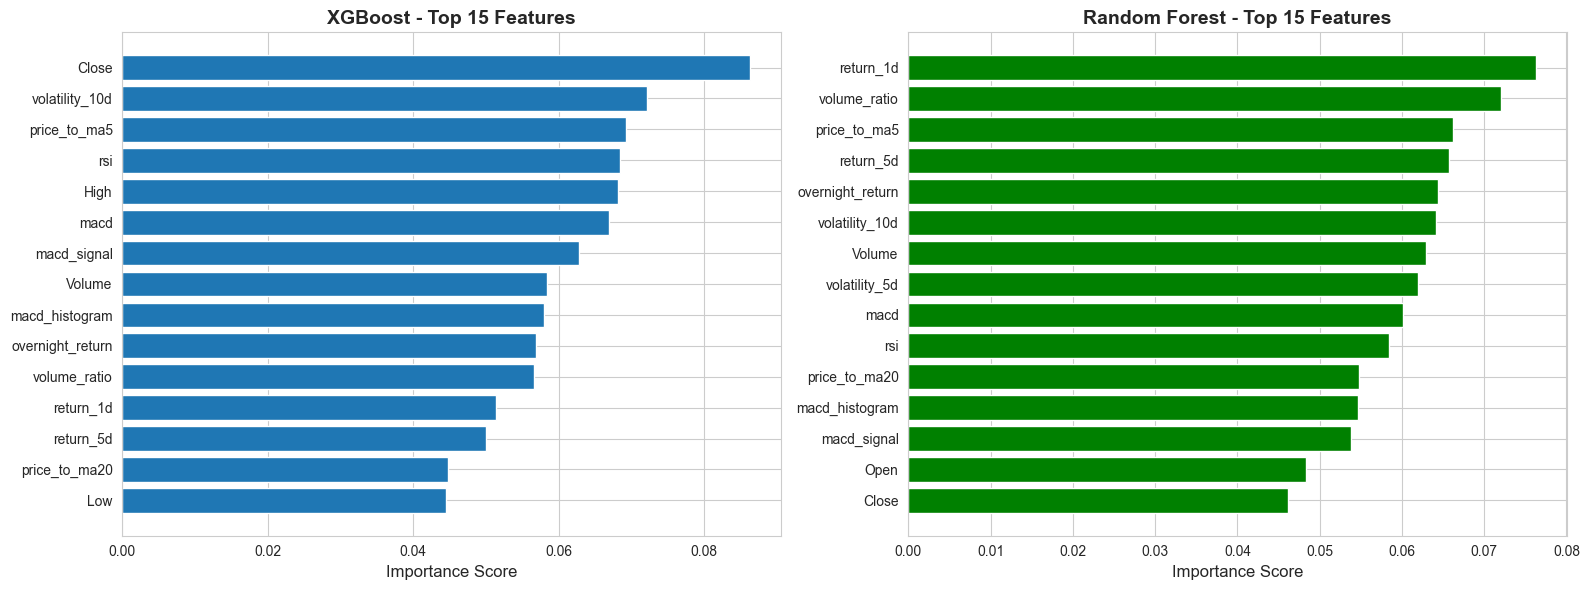


Top 10 Features (XGBoost):
         feature  importance
           Close    0.086259
  volatility_10d    0.072131
    price_to_ma5    0.069263
             rsi    0.068437
            High    0.068199
            macd    0.066985
     macd_signal    0.062752
          Volume    0.058436
  macd_histogram    0.057940
overnight_return    0.056911

Top 10 Features (Random Forest):
         feature  importance
       return_1d    0.076263
    volume_ratio    0.071988
    price_to_ma5    0.066153
       return_5d    0.065775
overnight_return    0.064427
  volatility_10d    0.064144
          Volume    0.062877
   volatility_5d    0.061954
            macd    0.060074
             rsi    0.058381


In [9]:
# Get feature importance from both models
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# XGBoost importance
axes[0].barh(xgb_importance['feature'][:15], xgb_importance['importance'][:15])
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('XGBoost - Top 15 Features', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Random Forest importance
axes[1].barh(rf_importance['feature'][:15], rf_importance['importance'][:15], color='green')
axes[1].set_xlabel('Importance Score', fontsize=12)
axes[1].set_title('Random Forest - Top 15 Features', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/figures/ml_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Features (XGBoost):")
print(xgb_importance.head(10).to_string(index=False))

print("\nTop 10 Features (Random Forest):")
print(rf_importance.head(10).to_string(index=False))

## 5. Confusion Matrix Visualization

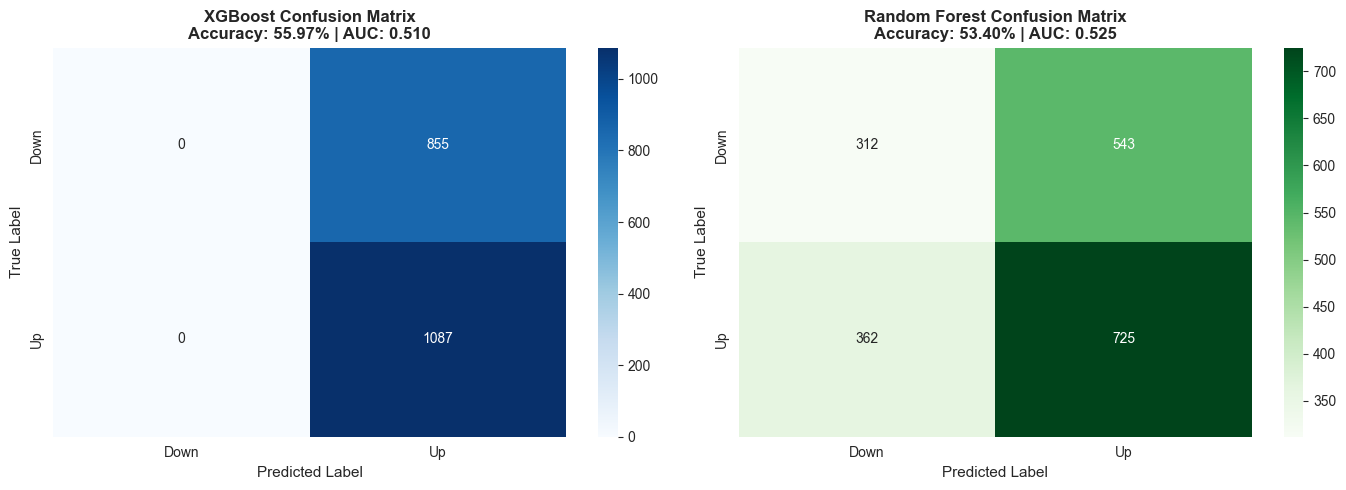

In [10]:
# Plot confusion matrices for binary classification
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost confusion matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Down', 'Up'],
            yticklabels=['Down', 'Up'])
axes[0].set_title(f'XGBoost Confusion Matrix\nAccuracy: {xgb_accuracy:.2%} | AUC: {xgb_auc:.3f}', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# Random Forest confusion matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Down', 'Up'],
            yticklabels=['Down', 'Up'])
axes[1].set_title(f'Random Forest Confusion Matrix\nAccuracy: {rf_accuracy:.2%} | AUC: {rf_auc:.3f}', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.savefig('../reports/figures/binary_ml_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 4.5 ROC Curves

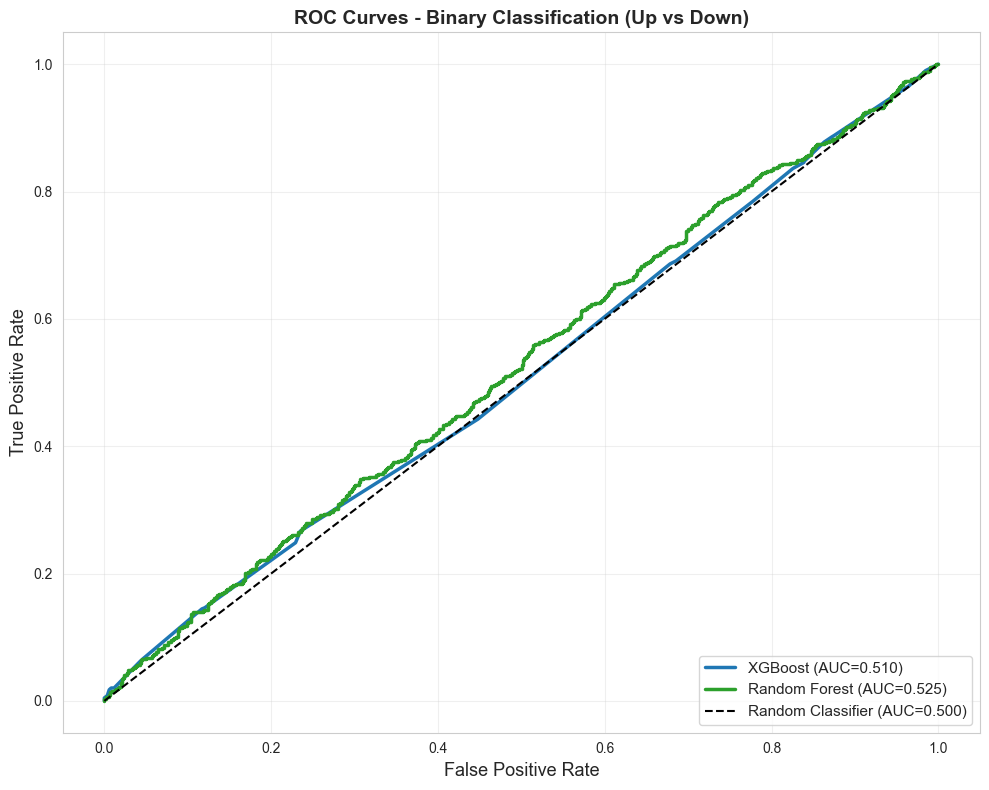


ROC-AUC Scores:
  XGBoost:       0.5104
  Random Forest: 0.5254


In [11]:
# Plot ROC curves for both models
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(10, 8))

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
ax.plot(fpr_xgb, tpr_xgb, linewidth=2.5, label=f'XGBoost (AUC={xgb_auc:.3f})', color='#1f77b4')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
ax.plot(fpr_rf, tpr_rf, linewidth=2.5, label=f'Random Forest (AUC={rf_auc:.3f})', color='#2ca02c')

# Diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier (AUC=0.500)')

ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curves - Binary Classification (Up vs Down)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/binary_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nROC-AUC Scores:")
print(f"  XGBoost:       {xgb_auc:.4f}")
print(f"  Random Forest: {rf_auc:.4f}")

## 6. Model Comparison Summary

In [12]:
# Compare all models
comparison_data = {
    'Model': ['XGBoost', 'Random Forest'],
    'Test Accuracy': [xgb_accuracy, rf_accuracy],
    'ROC-AUC': [xgb_auc, rf_auc],
    'Training Samples': [len(X_train), len(X_train)],
    'Features': [len(feature_cols), len(feature_cols)]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*60)
print("BINARY CLASSIFICATION - MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.to_string(index=False))

# Save results
results = {
    'classification_type': 'binary',
    'classes': ['Down (-1)', 'Up (+1)'],
    'xgboost': {
        'accuracy': float(xgb_accuracy),
        'roc_auc': float(xgb_auc),
        'confusion_matrix': cm_xgb.tolist(),
        'top_features': xgb_importance.head(10).to_dict('records')
    },
    'random_forest': {
        'accuracy': float(rf_accuracy),
        'roc_auc': float(rf_auc),
        'confusion_matrix': cm_rf.tolist(),
        'top_features': rf_importance.head(10).to_dict('records')
    }
}

with open('../models/binary_ml_models_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✓ Results saved to models/binary_ml_models_results.json")


BINARY CLASSIFICATION - MODEL COMPARISON SUMMARY
        Model  Test Accuracy  ROC-AUC  Training Samples  Features
      XGBoost       0.559732 0.510353              7026        25
Random Forest       0.533986 0.525408              7026        25

✓ Results saved to models/binary_ml_models_results.json


## 7. Save Trained Models

In [13]:
import joblib

# Save models
joblib.dump(xgb_model, '../models/xgboost_model.pkl')
joblib.dump(rf_model, '../models/random_forest_model.pkl')

print("✓ Models saved:")
print("  - models/xgboost_model.pkl")
print("  - models/random_forest_model.pkl")

✓ Models saved:
  - models/xgboost_model.pkl
  - models/random_forest_model.pkl


## Conclusion

This notebook demonstrated:
- Training XGBoost and Random Forest for **binary classification** (Up vs Down)
- Evaluating model performance with accuracy and ROC-AUC metrics
- Analyzing feature importance to understand prediction drivers
- Comparing traditional ML models with confusion matrices and ROC curves

**Key Findings - Binary Classification:**
- Removed neutral class for clearer decision boundary
- Both models provide interpretable feature importance
- ROC-AUC scores show model discrimination ability
- Traditional ML models serve as strong baselines

**Binary vs 3-Class Benefits:**
- Higher accuracy (no neutral dilution)
- Clearer trading signals (up or down only)
- Better ROC-AUC for model selection
- More actionable predictions

**Next Steps:**
- Compare with LSTM results from notebook 03
- Implement ensemble methods combining ML and DL
- Hyperparameter optimization for both models
- Backtesting with binary predictions